<a href="https://colab.research.google.com/github/CALDISS-AAU/sdsphd19_coursematerials/blob/master/notebooks/CALDISS_PHD_Intro_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preample

## Import Standard Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import itertools # Python's amazing iteration & combination library

# For visualization
!pip install -U bokeh
!pip install -q holoviews

Requirement already up-to-date: bokeh in /usr/local/lib/python3.6/dist-packages (1.4.0)


# Introduction

Welcome to your first part of the introduction to network analysis. In this session you will learn:

1. Why applying network analysis is helpful to answer certain questions, and why framing certain contexts as networks gives new insights.
2. The basic structure of relational data.
3. How to construct graph objects from different datasources.
4. How to analyse basic features of nodes, edges, and graphs.
5. How to identify groups and communities in graphs.
6. How to do simple network visualizations.

## So what?
So, before we talk about networks, one thing upfront... why should we? I mean, they undeniably look pretty, don't they? Somehow, the visualization of networks fascinates the human mind (find a short TED talk on networks and how they depict our world [here](https://www.ted.com/talks/manuel_lima_a_visual_history_of_human_knowledge)), and has even inspired an own art movement, networkism (see some examples [here](https://www.behance.net/gallery/184045/Links)). 

Yet, besides that, is there an analytical value for a data scientist to bother about networks?

![](https://www.dropbox.com/s/b8x2iwhaxacheem/networks_google_apple.png?dl=1)

## The basic jargon

First of all, what is a network? Plainly speaking, a network is a **system** of **elements** which are connected by some **relationship**. The vocabulary can be a bit technical and even inconsistent between different disciplines, packages, and software. 

The whole system is (surprise, surprise) usually called a **network** or **graph**. The elements are commonly referred to as **nodes** (system theory jargon) or **vertices** (graph theory jargon) of a graph, while the connections are **edges** or **links**. I will mostly refer to the elements as nodes, and their connections as edges.

![](https://www.dropbox.com/s/ap0e5exjtvtohju/networks_network_illu.png?dl=1)


Generally, networks are a form of representing **relational data**. This is a very general tool that can be applied to many different types of relationships between all kind of elements. The content, meaning, and interpretation for sure depends on what elements we display, and which types of relationships. For example:

* In Social Network Analysis:
     * Nodes represent actors (which can be persons, firms and other socially constructed entities)
     * Edges represent relationships between this actors (friendship, interaction, co-affiliation, similarity ect.)
* Other types of network
     * Chemistry: Interaction between molecules
     * Computer Science: The wirld-wide-web, inter- and intranet topologies
     * Biology: Food-web, ant-hives

The possibilities to depict relational data are manifold. For example:

* Relations among persons
     * Kinship: mother of, wife of...
     * Other role based: boss of, supervisor of...
     * Affective: likes, trusts...
     * Interaction: give advice, talks to, retweets...
     * Affiliation: belong to same clubs, shares same interests...
* Relations among organizations
     * As corporate entities, joint ventures, strategic alliances
     * Buy from / sell to, leases to, outsources to
     * Owns shares of, subsidiary of
     * Via their members (Personnel flows, friendship...)

# Relational data-structures

## Edgelist
Most real world relational data is to be found in what we call an **edge list**, a dataframe that contains a minimum of two columns, one column of *nodes* that are the source of a connection and another column of nodes that are the target of the connection. The nodes in the data are identified by unique IDs.

If the distinction between source and target is meaningful, the network is **directed**. If the distinction is not meaningful, the network is **undirected** (more on that later). So, every row that contains the ID of one element in column 1, and the ID of another element in column 2 indicates that a connection between them exists. 

An edge list can also contain additional columns that describe **attributes** of the edges such as a magnitude aspect for an edge. If the edges have a magnitude attribute the graph is considered **weighted** (e.g., number of interactions, strenght of friendship). 

Below an example ofa minimal edge list created with the `tibble()` function. In this case, let us assume this network to be unweighted, meaning a connection can be eiter tresent or absent.

In [0]:
edge_list = [
    ('A', 'B'),
    ('B', 'C'),
    ('A', 'C'),
    ('C', 'D')
]

edge_list

[('A', 'B'), ('B', 'C'), ('A', 'C'), ('C', 'D')]

## Adjacency Matrix

A second popular form of network representation is the **adjacency-matrix** (also called **socio-matrix**). It is represented as a $n*n$ matrix, where $n$ stands for the number of elements of which their relationships should be represented. The value in the cell that intercepts row $n$ and column $m$ indicates if an edge is present (=1) or absent (=0).

Tip: Given an edgelist, an adjacency matrix can easily be produced by crosstabulating:

In [0]:
adj_matrix = np.array([[0, 1, 1],
                       [1, 0, 1],
                       [1, 1, 0]])

print(adj_matrix)

[[0 1 1]
 [1 0 1]
 [1 1 0]]


*Note:* Existing as well as not existing connections are stored. Since most networks in reality are **sparse** (= more potential connections are inactive than active), this is inneficient for storrage and computation. 

In [0]:
from scipy.sparse import csr_matrix # for working with sparse matrices

sparse_matrix = csr_matrix(adj_matrix)

print(sparse_matrix)

  (0, 1)	1
  (0, 2)	1
  (1, 0)	1
  (1, 2)	1
  (2, 0)	1
  (2, 1)	1


## Nodelists
Edgelists as well as adjacency matrices only stores connectivity pattern between nodes, but due to their structure cannot store informations on the nodes in which we might be interested. Therefore, we in many cases also provide a a **node list** with these informations (such as the names of the nodes or any kind of groupings).

In [0]:
#node_list <- tibble(id = 1:5, 
#                    name = c("Jesper", "Pernille", "Jacob", "Dorte", "Donald"),
#                    gender = c("M", "F", "M", "F", "M"),
#                    group = c("A", "B", "B", "A", "C"))
#node_list

## Graph Objects

Up to now we see that relatonal data, and the analysis thereof, has some particularities, making it distinct from tabular data (e.g., dataframes), we usually work with. 

* Tabular data
     * In tabular data, summary statistics of variables are **between observations** (column-wise) interdependent, meaning changing a value of some observation will change the corresponding variables summary statistics.
     * LIkewise, variable values might be **within observation** interdependent (row-wise), meaning changing a variable value might change summary statistics of the observation
     * Otherwise, values are (at least mathematically) independent.
* Graph data
     * Same holds true, but adittional interdependencies due to the relational structure of the data.
     * Sepperation between **node** and **edge** data, which is interdependent. Removing a node might alos impy the removal of edges, removal of edges changes the characteristics of nodes
     * In adittion, the relational structure makes that not only true for adjacent nodes and edges, but potentially multiple. Adding/Removing one node/edge could change the characteristics of every single other node/edge.
     * That is less of a problem for local network characteristics (eg., a node's degree on level 1). However, many node and edge characteristics such
     * That's mainly why graph computing is slightly more messy, and need own mathematical tools, and applications from graphical computing (graphical like graph, not like figure)

![](https://www.dropbox.com/s/y9mp6yarctm7ysd/networks_data_structure.png?dl=1)

Therefore, network analysis packages in `R`, `Python`, and elsewhere usually define own graph objects (containing information on nodes as well as edges), in which network data for further analysis is stored.

We in the following will work with the [`networkx`](https://networkx.github.io/documentation/stable/index.html) library, which is the standard for network analysis in the Python community. Another popular package more from the graph-theorist community is [`igraph`](https://igraph.org/python/), which is also the main package used for network analysis in the `R` community. However, since `networkx` became the `Python` standard, we will in the following stick to it.

### Graph concepts & terminology

Before we start creating graphs, lets fix some more terminology related to graphs. Some of them might sound unintuitive by now, but we will come back to that later.

* The vertices `u` and `v` are called the end vertices of the edge `(u,v)`
* If two edges have the same end vertices they are `Parallel`
* An edge of the form `(v,v)` is a `loop`
* A Graph is `simple` if it has no parallel edges and loops
* A Graph is said to be `Empty` if it has no edges. Meaning `E` is empty
* A Graph is a `Null` Graph if it has no vertices. Meaning `V` and `E` is empty
* Edges are `Adjacent` if they have a common vertex. Vertices are `Adjacent` if they have a common edge
* The `degree` of the vertex `v`, written as `d(v)`, is the number of edges with v as an end vertex. By convention, we count a loop twice and parallel edges contribute separately
* `Isolated` Vertices are vertices with degree 1.
* A Graph is `Complete` or fully-connected if its edge set contains every possible edge between ALL of the vertices
* A `Walk` in a Graph` G = (V,E)` is a finite, alternating sequence of the form  ViEiViEi  consisting of vertices and edges of the graph `G`
* A `Walk` is `Open` if the initial and final vertices are different. A `Walk` is `Closed` if the initial and final vertices are the same
* A `Walk` is a `Path` if ANY vertex is appear atmost once (Except for a closed walk)


### Types of Graphs


1. Weigthed vs. Unweighted
2. Directed vs. Undirected
3. Unimodal vs. Multimodal
4. Unidimensional vs. Multidimensional

`networkx` graph classes
1. Graph
2. DiGraph
3. MultiGraph
4. MultiDigraph

### Creating a graph object

The graph object forms the core of network analysis. This is the central place where nodes, edges, and their characteristics are jointly stored. Lets take a look how to create one.

In [0]:
# Import the library
import networkx as nx

In [0]:
# We can create a network graph G directly from the adjacency matrix.
G = nx.from_numpy_array(adj_matrix)
print(G.nodes(), G.edges())

[0, 1, 2] [(0, 1), (0, 2), (1, 2)]


In [0]:
# We can also directly load an edgelist instead
G = nx.from_edgelist(edge_list)
print(G.nodes(), G.edges())

['A', 'B', 'C', 'D'] [('A', 'B'), ('A', 'C'), ('B', 'C'), ('C', 'D')]


In [0]:
# We can also create an own graph
G = nx.Graph() # create an empty graph with no nodes and no edges
print(G.nodes(), G.edges())

[] []


In [0]:
G.add_nodes_from([1, 2, 3, 4, 5]) # add a list of nodes
G.add_edges_from([(1,2), (1,3), (4,5), (5,3), (4,2), (3,2), (1,4)]) # add a list of edges
print(G.nodes(), G.edges())

[1, 2, 3, 4, 5] [(1, 2), (1, 3), (1, 4), (2, 4), (2, 3), (3, 5), (4, 5)]


Ok, up to now that was pretty abstract, right? Lets plot the graph to get a feeling what the network looks like. We will explore this later more exhaustive. 

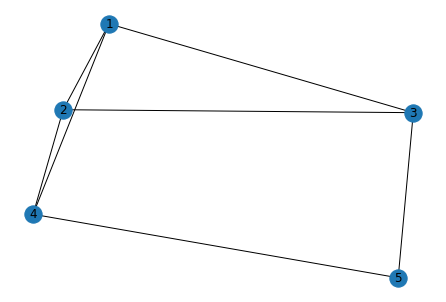

In [0]:
nx.draw(G, with_labels=True)


### Your turn!

So, now its already time for a little exercise: Try to create and plot the following network structure. Have fun :)

![](https://www.dropbox.com/s/88anz0w24kurckp/networks_mini_exercise.png?dl=1)

In [0]:
# First, create an empty graph

In [0]:
# Now, add the nodes

In [0]:
# And also the edges

In [0]:
# And finally, plot it

# Network analysis and measures
The reasons we are dealing with graph data in the first place is because we need some *graph-based algorithms* for solving our problem at hand. 

So, lets take a look at commonly used metrics to describe, characterize and analyse networks, nodes, and edges.


## Network data

We now will load some sample data

In [0]:
G = nx.les_miserables_graph()

In [0]:
G.nodes()

NodeView(('Napoleon', 'Myriel', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan', 'Valjean', 'Labarre', 'Marguerite', 'MmeDeR', 'Isabeau', 'Gervais', 'Listolier', 'Tholomyes', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'MmeThenardier', 'Thenardier', 'Cosette', 'Javert', 'Fauchelevent', 'Bamatabois', 'Perpetue', 'Simplice', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Pontmercy', 'Boulatruelle', 'Eponine', 'Anzelma', 'Woman2', 'MotherInnocent', 'Gribier', 'MmeBurgon', 'Jondrette', 'Gavroche', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Toussaint', 'Child1', 'Child2', 'Brujon', 'MmeHucheloup'))

In [0]:
G.edges()

EdgeView([('Napoleon', 'Myriel'), ('Myriel', 'MlleBaptistine'), ('Myriel', 'MmeMagloire'), ('Myriel', 'CountessDeLo'), ('Myriel', 'Geborand'), ('Myriel', 'Champtercier'), ('Myriel', 'Cravatte'), ('Myriel', 'Count'), ('Myriel', 'OldMan'), ('Myriel', 'Valjean'), ('MlleBaptistine', 'MmeMagloire'), ('MlleBaptistine', 'Valjean'), ('MmeMagloire', 'Valjean'), ('Valjean', 'Labarre'), ('Valjean', 'Marguerite'), ('Valjean', 'MmeDeR'), ('Valjean', 'Isabeau'), ('Valjean', 'Gervais'), ('Valjean', 'Fantine'), ('Valjean', 'MmeThenardier'), ('Valjean', 'Thenardier'), ('Valjean', 'Cosette'), ('Valjean', 'Javert'), ('Valjean', 'Fauchelevent'), ('Valjean', 'Bamatabois'), ('Valjean', 'Simplice'), ('Valjean', 'Scaufflaire'), ('Valjean', 'Woman1'), ('Valjean', 'Judge'), ('Valjean', 'Champmathieu'), ('Valjean', 'Brevet'), ('Valjean', 'Chenildieu'), ('Valjean', 'Cochepaille'), ('Valjean', 'Woman2'), ('Valjean', 'MotherInnocent'), ('Valjean', 'Gavroche'), ('Valjean', 'Gillenormand'), ('Valjean', 'MlleGillenorm

In [0]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 77
Number of edges: 254
Average degree:   6.5974


Lets take a first visual peek. For a non-trivial (not like the one before) visualization of networks, the way how nodes and edges are placed in the plot makes a big difference in terms of how informative the visualization is, and how much information we can get out of it. 

There are plenty of different algorithms to optimize node and edge positions in visualizations within a graph **layout**. [Here](https://networkx.github.io/documentation/stable/reference/drawing.html#module-networkx.drawing.layout) you find an overview over the ones implemented in `networkx`.

We can usually render these layouts on the fly when plotting the graph object. Since these algorithms contain probabilistic and iterative elements, they might look slightly different from plot to plot, though. Since we will plot this network a couple of times during this tutorial and want to compare them among each others, we will create and save the layout already upfront and pass it every time to the plotting function to make sure that the nodes are always placed in the same position.

Here, we use the *Fruchterman-Reingold* algorithm-one of the most commonly used ones-to create the layout.

In [0]:
# Create and save a layout.
G_layout = nx.layout.fruchterman_reingold_layout(G) 

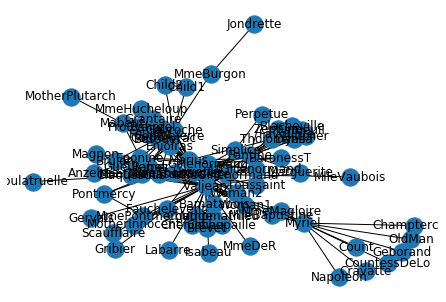

In [0]:
# We use the standard networkx plot, and pass the layout.
nx.draw(G, layout = G_layout, with_labels=True)

Well, we somewhat an intuition of the network architecture, containing a core-region, and some periphral centers. Otherwise, it's rather uninformative. Good network visualization after all is more than just doing a standard plot, so there is much we can do to make it more informative. However, we get to that later. 

In this case, we have a weighted graph, meaning that an edge does not only exist or not, (binary), but rather weighted by the number of the nodes (representing characters) interaction. 

In [0]:
nx.get_edge_attributes(G, 'weight')

{('Babet', 'Brujon'): 3,
 ('Babet', 'Claquesous'): 4,
 ('Babet', 'Montparnasse'): 2,
 ('Bahorel', 'Bossuet'): 4,
 ('Bahorel', 'Grantaire'): 1,
 ('Bahorel', 'Joly'): 5,
 ('Bahorel', 'MmeHucheloup'): 1,
 ('Bamatabois', 'Brevet'): 1,
 ('Bamatabois', 'Champmathieu'): 2,
 ('Bamatabois', 'Chenildieu'): 1,
 ('Bamatabois', 'Cochepaille'): 1,
 ('Bamatabois', 'Judge'): 2,
 ('Blacheville', 'Dahlia'): 3,
 ('Blacheville', 'Fantine'): 3,
 ('Blacheville', 'Favourite'): 4,
 ('Blacheville', 'Zephine'): 3,
 ('Bossuet', 'Grantaire'): 3,
 ('Bossuet', 'Joly'): 7,
 ('Bossuet', 'MmeHucheloup'): 1,
 ('Brevet', 'Chenildieu'): 2,
 ('Brevet', 'Cochepaille'): 2,
 ('Champmathieu', 'Brevet'): 2,
 ('Champmathieu', 'Chenildieu'): 2,
 ('Champmathieu', 'Cochepaille'): 2,
 ('Chenildieu', 'Cochepaille'): 2,
 ('Child1', 'Child2'): 3,
 ('Claquesous', 'Brujon'): 1,
 ('Claquesous', 'Montparnasse'): 2,
 ('Combeferre', 'Bahorel'): 5,
 ('Combeferre', 'Bossuet'): 9,
 ('Combeferre', 'Courfeyrac'): 13,
 ('Combeferre', 'Feuilly'): 

We see that the edge weights vary quite a lot. For this simple example we will remove the weights to give us a undirected and unweighted graph.

In [0]:
for n1, n2, d in G.edges(data=True):
  d.pop('weight', None)

We can even do better! We can use the powerful [`bokeh`](https://docs.bokeh.org/) library (we installed it in the preamble). However, it is very clunky to work with. The [`hollowviews`](http://holoviews.org/user_guide/Network_Graphs.html) library in turn provides a lightweight wrapper that enables us to produce pretty interactive visualizations with a few lines of code. Lets do that!

PS: Try to hover over the nodes :-)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
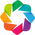

In [0]:
# Import the libraries and link to the bokeh backend
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')
from bokeh.plotting import show

# Setting the default figure size a bit larger
defaults = dict(width=750, height=750, padding=0.1,
                xaxis=None, yaxis=None)
hv.opts.defaults(
    opts.EdgePaths(**defaults), opts.Graph(**defaults), opts.Nodes(**defaults))



In [0]:
g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'])

In [0]:
show(hv.render(g_plot))

## Node-Level measures

Often, we are interested in ways to summarize the pattern of node connectivity to infer something on their characteristics. 


One of the simplest concepts when computing node level measures is that of **centrality**, i.e. how central is a node or edge in the graph. As this definition is inherently vague, a lot of different centrality scores exists that all treat the concept of "central" a bit different. 

We in the following well briefly illustrate the idea behind three of the most popular centrality measures, namely:

* Degree centrality
* Eigenvector centrality
* Betweenness centrality

### Degree centrality
The degree centrality is probably the most intuitive node measure, which basically just counts the number of edges adjacent to a node.  Formally, the degree of node $i$ is the number of existing edges $e_{ij}$ with other nodes $j$ in a network with $n$ nodes:

$$d_{ij} =\sum\limits_{j=1}^{n} e_{ij} ~ where: ~ i \neq j$$

In [0]:
cent_degree = dict(nx.degree(G))

In [0]:
cent_degree.values()

dict_values([1, 10, 3, 3, 1, 1, 1, 1, 1, 1, 36, 1, 2, 1, 1, 1, 7, 9, 7, 7, 7, 7, 7, 15, 11, 16, 11, 17, 4, 8, 2, 4, 1, 2, 6, 6, 6, 6, 6, 3, 1, 11, 3, 3, 2, 1, 2, 1, 22, 7, 2, 7, 2, 1, 4, 19, 2, 11, 15, 11, 9, 11, 13, 12, 13, 12, 10, 1, 10, 10, 10, 9, 3, 2, 2, 7, 7])

In [0]:
sorted(cent_degree.items(),key=lambda x:-x[1])[:10]

[('Valjean', 36),
 ('Gavroche', 22),
 ('Marius', 19),
 ('Javert', 17),
 ('Thenardier', 16),
 ('Fantine', 15),
 ('Enjolras', 15),
 ('Courfeyrac', 13),
 ('Bossuet', 13),
 ('Bahorel', 12)]

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e6/Gavroche_%28Les_Misérables%29.jpg/162px-Gavroche_%28Les_Misérables%29.jpg)

The most important character is *Valjean*, the main character, not that surprising. But the second most important character is *Gavroche*. Is that right? Lets have a look at the graph so we can see what is going on :-)

**Note**: Node size represents degree centrality - Bigger nodes indicate degree centrality.

In [0]:
nx.set_node_attributes(G, cent_degree, 'cent_degree')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_degree')

show(hv.render(g_plot))

### Eigenvector centrality
Similar to the degree centrality, the eigenvector centrality takes this idea of characterizing nodes by their importance in a network a step further. It also represents the main idea behind the pagerank algorithm (a variant of eigenvector centrality) that was powering Google Search in the beginning. 

The basic idea is to weight a node's degree centrality by the centrality of the nodes adjacent to it (and their centrality in turn by their centrality). This will make nodes connected to in turn also well connected nodes more important. The eigenvector here is just a clever mathematical trick to solve such a recurrent problem.

$$x_{v}={\frac {1}{\lambda }}\sum _{t\in M(v)}x_{t}={\frac {1}{\lambda }}\sum _{t\in G}a_{v,t}x_{t}$$

In [0]:
cent_eigen = dict(nx.eigenvector_centrality(G))

In [0]:
sorted(cent_eigen.items(),key=lambda x:-x[1])[:10]

[('Gavroche', 0.31783893977497674),
 ('Valjean', 0.2676181759885393),
 ('Enjolras', 0.26717863282356663),
 ('Marius', 0.25911114534178753),
 ('Bossuet', 0.24213078637474134),
 ('Courfeyrac', 0.23246719717021405),
 ('Bahorel', 0.22155360926119963),
 ('Joly', 0.22155360926119963),
 ('Combeferre', 0.21073457488115616),
 ('Feuilly', 0.21073457488115616)]

In [0]:
nx.set_node_attributes(G, cent_eigen, 'cent_eigen')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_eigen' )

show(hv.render(g_plot))

### Betweenness centrality

* The betweenness centrality of an object in a network measures the extent to which it lies on short paths
* A higher betweenness indicates that it lies on more short paths and hence should somehow be important for traversing between different parts of a network
* How many pairs of individuals would have to go through you in order to reach one another in the minimum number of hops? Who has higher betweenness, X or Y?

In formulaic representation

* The geodesic betweenness $B_{n}(i)$ of a **vertex** in a weighted, undirected network is
$$B_{n}(i) =  \sum_{s,t \in G} \frac{ \Psi_{s,t}(i) }{\Psi_{s,t}}$$
where vertices $s,t,i$ are all different from each other

* $\Psi_{s,t}$ denotes the number of shortest paths (geodesics) between vertices $s$ and $t$
* $\Psi_{s,t}(i)$ denotes the number of shortest paths (geodesics) between vertices $s$ and $t$ **that pass through vertex** $i$.
* The geodesic betweenness $B_n$ of a network is the mean of $B_n(i)$ over all vertices $i$

In [0]:
cent_between = nx.betweenness_centrality(G)
sorted(cent_between.items(),key=lambda x:-x[1])[:10]

[('Valjean', 0.5699890527836184),
 ('Myriel', 0.17684210526315788),
 ('Gavroche', 0.16511250242584766),
 ('Marius', 0.132032488621946),
 ('Fantine', 0.12964454098819422),
 ('Thenardier', 0.07490122123424225),
 ('Javert', 0.05433155966478436),
 ('MlleGillenormand', 0.047598927875243675),
 ('Enjolras', 0.0425533568221771),
 ('Tholomyes', 0.04062934817733579)]

In [0]:
nx.set_node_attributes(G, cent_between, 'cent_between')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_between' )

show(hv.render(g_plot))

## Neighborhood of a Node

Further, we can look at the surrounding of a node, meaning the ones it is connected to, its **neighborhood**. Here, we can look at the **ego-network of a node**. That means how many nodes are in a certain **geodesic distance**, meaning the **shortest path**. Plainly speaking, how many nodes are not more than x-steps away.

![](https://www.dropbox.com/s/yat7qsdfszmc1d1/networks_distance.jpg?dl=1)




In [0]:
path = list(nx.all_shortest_paths(G, source="Valjean", target="Tholomyes"))
print(path)

[['Valjean', 'Fantine', 'Tholomyes'], ['Valjean', 'Cosette', 'Tholomyes'], ['Valjean', 'Marius', 'Tholomyes']]


In [0]:
print(list(G.neighbors("Valjean")))

['Labarre', 'MmeMagloire', 'MlleBaptistine', 'Myriel', 'Marguerite', 'MmeDeR', 'Isabeau', 'Gervais', 'Fantine', 'MmeThenardier', 'Thenardier', 'Cosette', 'Javert', 'Fauchelevent', 'Bamatabois', 'Simplice', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Woman2', 'MotherInnocent', 'Gavroche', 'Gillenormand', 'MlleGillenormand', 'Marius', 'Enjolras', 'Bossuet', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Toussaint']


In [0]:
len(list(G.neighbors("Valjean")))

36

In [0]:
def neighborhood(G, node, n):
    path_lengths = nx.single_source_dijkstra_path_length(G, node)
    return [node for node, length in path_lengths.items()
                    if length == n]

In [0]:
print(neighborhood(G, 'Valjean', 2))

['Napoleon', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan', 'Tholomyes', 'Listolier', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Perpetue', 'Eponine', 'Anzelma', 'Magnon', 'Pontmercy', 'Boulatruelle', 'Brujon', 'LtGillenormand', 'Gribier', 'MmeBurgon', 'Mabeuf', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Joly', 'Grantaire', 'Child1', 'Child2', 'MmeHucheloup', 'BaronessT', 'MmePontmercy', 'MlleVaubois']


## Clustering (Community detection)

Another common operation is to group nodes based on the graph topology, sometimes referred to as *community detection* based on its commonality in social network analysis.

There are-just like for clustering of tabular data in UML-many different algorithms and approaches to detect and delineate communities. [Here](https://github.com/benedekrozemberczki/awesome-community-detection) you find a summary of currently used approaches.

The main logic in most cases is to find ways to form groups which have a maximum *within-connectivity* and a minimum *between-connectivity*. Consequently, nodes in the same community should have a higher probability of being connected than nodes from different communities.

Here we will use the **Louvain Method**, one of the most widely used community detection algorithms. It usually delivers good results, scales well, and can handle weighted networks. Furthermore, there is an actively maintained, easy to use Python implementation, [`python-louvain`](https://python-louvain.readthedocs.io).

It optimises a quantity called modularity:

$$  \sum_{ij} (A_{ij} - \lambda P_{ij}) \delta(c_i,c_j) $$

$A$ - The adjacency matrix

$P_{ij}$ - The expected connection between $i$ and $j$.

$\lambda$ - Resolution parameter

Can use lots of different forms for $P_{ij}$ but the standard one is the so called configuration model:

$P_{ij} = \frac{k_i k_j}{2m}$

Loosely speaking, in an iterative process it 

1. You take a node and try to aggregate it to one of its neighbours.
2. You choose the neighbour that maximizes a modularity function. This function tells you how connected is the community you are trying to attach your node to going to be if you actually attach your node to it (this function is easy to compute and this makes Louvain very fast!).
3. Once you iterate through all the nodes, you will have merged few nodes together and formed some communities.
4. This becomes the new input for the algorithm that will treat each community as a node and try to merge them together to create bigger communities.
5. The algorithm stops when it's not possible to improve modularity any more. 

![](https://www.dropbox.com/s/afoeq2pa01lba50/networks_louvain.jpg?dl=1)

This is the original paper, for those interested in further reads:

* Blondel, Vincent D; Guillaume, Jean-Loup; Lambiotte, Renaud; Lefebvre, Etienne (9 October 2008). "Fast unfolding of communities in large networks". Journal of Statistical Mechanics: Theory and Experiment. 2008 (10): P10008

Lets take a look how that works:


In [0]:
# Import libraries
import community # `python-louvain` is implemented here

In [0]:
# Find the optimal partition with the Louvain algorithm.
community = community.best_partition(G)

In [0]:
# The number of communities detected
max(community.values())

6

In [0]:
nx.set_node_attributes(G, community, 'community')

g_plot = hv.Graph.from_networkx(G, G_layout).opts(tools=['hover'],
                                                  node_size='cent_degree', 
                                                  node_color='community', cmap=plt.cm.Set1,
                                                  legend_position='right')

show(hv.render(g_plot))

## (Global) Network structure

Finally, it is often also informative to look at the overal characteristics of the network.


The **density** of a measure represents the share of all connected to all possible connections in the network

In [0]:
nx.density(G)

**Transistivity**, also called the **Clustering Cefficient** indicates how much the network tends to be locally clustered. That is measured by the share of **closed triplets**. Again,w e will dig into that next time.

![](https://www.dropbox.com/s/ei585dd6ysa243d/networks_ccoeff.png?dl=1)

In [0]:
nx.transitivity(G)

0.49893162393162394

The **diameter** is the longest of the shortest paths between two nodes of the network.

In [0]:
nx.diameter(G)

5

Finally, the **mean distance**, or **average path lenght** represents the mean of all shortest paths between all nodes. It is a measure of diffusion potential within a network.

In [0]:
nx.average_shortest_path_length(G)

2.6411483253588517

# Multi-Modal Networks




## What's that?
Now its time to talk about an interesting type of networks, multi-modal. This means, a network has several "modes", meaning connects entities on different conceptual levels. The most commone one is a **2-mode** (or **bipartite**) network. 

Examples could be an 

* Author $\rightarrow$ Paper
* Inventor $\rightarrow$ Patent
* Member $\rightarrow$ Club network. 

Here, the elements in the different modes represent different things. In interesting real-life research examples you find 2-mode networks for instance in co-occurence (2 actors mentioned in the same news-article), co-affiliation (2 actors are member of the same association), or co-characteristics (2 actors both like to talk about a certain topic on twitter).

## Network Projections

Two-mode networks are rarely analysed in their original form. Although this is preferable, few methods exist for that purpose. As such, these networks are often transformed into one-mode networks (only one type of nodes) to be analysed. This procedure is often referred to as projection. Projection is done by selecting one of the sets of nodes and linking two nodes from that set if they were connected to the same node (of the other kind).

We can alalyse them in sepperation (and sometimes we should), but often its helpful to *project* them onto one mode. Here, we create a node in one mode by joint association with another mode.

2-mode

![](https://toreopsahl.files.wordpress.com/2009/04/fig1_twomode_half.png)

1-mode

![](https://toreopsahl.files.wordpress.com/2009/04/fig1_twomode_simple.png)

In my field, that often happens with scientometric data such as publications, but also patents or policy reports. Conceptually, we can see them as 2 mode networks, between articles and their reference. 


![](https://www.dropbox.com/s/e4vnq7kh24pyu0t/networks_2mode.png?dl=1)

Particularly in citation networks, we can also use the implicite 2-mode structure of $Publications \rightarrow Citation$

That helps us to apply some interesting metrics, such as:

* direct citations
* Bibliographic coupling
* Co--citations

Interestingly, different projections of this 2-mode network give the whole resulting 1-mode network a different meaning.

![](https://www.dropbox.com/s/f8g8nr83lucvpqx/networks_biblio.png?dl=1)

For an application, check:

* Rakas, M., & Hain, D. S. (2019). The state of innovation system research: What happens beneath the surface?. Research Policy.



## Weighted Network Projection

In a similar spirit as the method used by Newman (2001), it is also possible to discount for the number of nodes when projecting weighted two-mode networks.

 
 For example, it could be argued that if many online users post to a thread, their ties should be weaker than if there were few people posting to the thread. A straight forward generalisation is the following function: $w_{ij} = \sum_p \frac{w_{i,p}}{N_p - 1}$. 
 
 This formula would create a directed one-mode network in which the out-strength of a node is equal to the sum of the weights attached to the ties in the two-mode network that originated from that node. For example, node C has a tie with a weight of 5 in the two-mode network and an out-strength of 5 in the one-mode projection.

![](https://toreopsahl.files.wordpress.com/2009/04/fig1_twomode_forum_newman2001.png)

* Newman, M. E. J., 2001. Scientific collaboration networks. II. Shortest paths, weighted networks, and centrality. Physical Review E 64, 016132.

# Case Study: Directed Networks: Friends & Foes at Work

## Introduction to the case

* Emmanuel Lazega, The Collegial Phenomenon: The Social Mechanisms of Cooperation Among Peers in a Corporate Law Partnership, Oxford University Press (2001).

### Data 
This data set comes from a network study of corporate law partnership that was carried out in a Northeastern US corporate law firm, referred to as SG&R, 1988-1991 in New England. It includes (among others) measurements of networks among the 71 attorneys (partners and associates) of this firm, i.e. their strong-coworker network, advice network, friendship network, and indirect control networks. Various members' attributes are also part of the dataset, including seniority, formal status, office in which they work, gender, lawschool attended, individual performance measurements (hours worked, fees brought in), attitudes concerning various management policy options, etc. This dataset was used to identify social processes such as bounded solidarity, lateral control, quality control, knowledge sharing, balancing powers, regulation, etc. among peers.

### Setting
* What do corporate lawyers do? Litigation and corporate work.
* Division of work and interdependencies.
* Three offices, no departments, built-in pressures to grow, intake and assignment rules.
* Partners and associates: hierarchy, up or out rule, billing targets.
* Partnership agreement (sharing benefits equally, 90% exclusion rule, governance structure, elusive committee system) and incompleteness of the contracts.
* Informal, unwritten rules (ex: no moonlighting, no investment in buildings, no nepotism, no borrowing to pay partners, etc.).
* Huge incentives to behave opportunistically ; thus the dataset is appropriate for the study of social processes that make cooperation among rival partners possible. 
* Sociometric name generators used to elicit coworkers, advice, and 'friendship' ties at SG&R:"Here is the list of all the members of your Firm."

The networks where created according to the follwoing questionaire:

* Strong coworkers network: "Because most firms like yours are also organized very informally, it is difficult to get a clear idea of how the members really work together. Think back over the past year, consider all the lawyers in your Firm. Would you go through this list and check the names of those with whom you have worked with. By "worked with" I mean that you have spent time together on at least one case, that you have been assigned to the same case, that they read or used your work product or that you have read or used their work product; this includes professional work done within the Firm like Bar association work, administration, etc."
* Basic advice network: "Think back over the past year, consider all the lawyers in your Firm. To whom did you go for basic professional advice? For instance, you want to make sure that you are handling a case right, making a proper decision, and you want to consult someone whose professional opinions are in general of great value to you. By advice I do not mean simply technical advice."
* 'Friendship' network:
"Would you go through this list, and check the names of those you socialize with outside work. You know their family, they know yours, for instance. I do not mean all the people you are simply on a friendly level with, or people you happen to meet at Firm functions." 

## Data preperation

###  Load the data

Lets load the data! The three networks refer to cowork, friendship, and advice. The first 36 respondents are the partners in the firm.

In [0]:
mat_friendship = pd.read_table("https://www.dropbox.com/s/0saiulir3pr566k/ELfriend.dat?dl=1", delim_whitespace=True, header=None) 
mat_advice = pd.read_table("https://www.dropbox.com/s/apq42n1grim23k9/ELadv.dat?dl=1", delim_whitespace=True, header=None) 
mat_work = pd.read_table("https://www.dropbox.com/s/dliz0sd7or8tv01/ELwork.dat?dl=1", delim_whitespace=True, header=None) 

In [0]:
mat_friendship.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,0,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0,1,1,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
G_friendship = nx.from_pandas_adjacency(mat_friendship, create_using=nx.DiGraph)
G_advice = nx.from_pandas_adjacency(mat_advice, create_using=nx.DiGraph)
G_work = nx.from_pandas_adjacency(mat_work, create_using=nx.DiGraph)

In [0]:
print(nx.info(G_friendship))
print(nx.info(G_advice))
print(nx.info(G_work))

Name: 
Type: DiGraph
Number of nodes: 71
Number of edges: 575
Average in degree:   8.0986
Average out degree:   8.0986
Name: 
Type: DiGraph
Number of nodes: 71
Number of edges: 892
Average in degree:  12.5634
Average out degree:  12.5634
Name: 
Type: DiGraph
Number of nodes: 71
Number of edges: 756
Average in degree:  10.6479
Average out degree:  10.6479


In [0]:
attributes = pd.read_table("https://www.dropbox.com/s/qz7fvfgx8lvjgpr/ELattr.dat?dl=1", delim_whitespace=True, header=None, dtype='int') 

In [0]:
attributes.head()

,0,1,2,3,4,5,6,7
0,1,1,1,1,31,64,1,1
1,2,1,1,1,32,62,2,1
2,3,1,1,2,13,67,1,1
3,4,1,1,1,31,59,2,3
4,5,1,1,2,31,59,1,2


In [0]:
attributes=attributes.round().astype(int)

In [0]:
attributes.columns = ["id", "seniority", "gender", "office", "tenure", "age", "practice", "school"]

In [0]:
attributes.set_index('id',inplace=True)

In [0]:
cleanup_nums = {"seniority":     {1: "Partner", 2: "Associate"},
                "gender":     {1: "Male", 2: "Female"},
                "office":     {1: "Boston", 2: "Hartford", 3:"Providence"},
                "practice":     {1: "Litigation", 2: "Corporate"},
                "school":     {1: "Harvard, Yale", 2: "Ucon", 3: "Others"}
                } 

In [0]:
attributes.replace(cleanup_nums, inplace=True)

In [0]:
attributes.head()

,seniority,gender,office,tenure,age,practice,school
id,,,,,,,
1,Partner,Male,Boston,31,64,Litigation,"Harvard, Yale"
2,Partner,Male,Boston,32,62,Corporate,"Harvard, Yale"
3,Partner,Male,Hartford,13,67,Litigation,"Harvard, Yale"
4,Partner,Male,Boston,31,59,Corporate,Others
5,Partner,Male,Hartford,31,59,Litigation,Ucon


In [0]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71 entries, 1 to 71
Data columns (total 7 columns):
seniority    71 non-null object
gender       71 non-null object
office       71 non-null object
tenure       71 non-null int64
age          71 non-null int64
practice     71 non-null object
school       71 non-null object
dtypes: int64(2), object(5)
memory usage: 4.4+ KB


In [0]:
attributes_dict=attributes.T.to_dict()

In [0]:
nx.set_node_attributes(G_friendship, attributes_dict)
nx.set_node_attributes(G_advice, attributes_dict)
nx.set_node_attributes(G_work, attributes_dict)

In [0]:
print(nx.get_node_attributes(G_friendship, 'seniority'))

{1: 'Partner', 2: 'Partner', 3: 'Partner', 4: 'Partner', 5: 'Partner', 6: 'Partner', 7: 'Partner', 8: 'Partner', 9: 'Partner', 10: 'Partner', 11: 'Partner', 12: 'Partner', 13: 'Partner', 14: 'Partner', 15: 'Partner', 16: 'Partner', 17: 'Partner', 18: 'Partner', 19: 'Partner', 20: 'Partner', 21: 'Partner', 22: 'Partner', 23: 'Partner', 24: 'Partner', 25: 'Partner', 26: 'Partner', 27: 'Partner', 28: 'Partner', 29: 'Partner', 30: 'Partner', 31: 'Partner', 32: 'Partner', 33: 'Partner', 34: 'Partner', 35: 'Partner', 36: 'Partner', 37: 'Associate', 38: 'Associate', 39: 'Associate', 40: 'Associate', 41: 'Associate', 42: 'Associate', 43: 'Associate', 44: 'Associate', 45: 'Associate', 46: 'Associate', 47: 'Associate', 48: 'Associate', 49: 'Associate', 50: 'Associate', 51: 'Associate', 52: 'Associate', 53: 'Associate', 54: 'Associate', 55: 'Associate', 56: 'Associate', 57: 'Associate', 58: 'Associate', 59: 'Associate', 60: 'Associate', 61: 'Associate', 62: 'Associate', 63: 'Associate', 64: 'Asso

## Calculate dimensional centralities

There might be better ways to do that (still experimenting), but for now lets first create centralities upfront for all networks. We for now only look at the in-degree.

In [0]:
cent_degree_friendship = dict(G_friendship.in_degree)
cent_degree_advice = dict(G_advice.in_degree)
cent_degree_work = dict(G_work.in_degree)

In [0]:
nx.set_node_attributes(G_friendship, cent_degree_friendship, 'cent_degree')
nx.set_node_attributes(G_advice, cent_degree_advice, 'cent_degree')
nx.set_node_attributes(G_work, cent_degree_work, 'cent_degree')

In [0]:
# Create and save a layout.
G_layout = nx.layout.kamada_kawai_layout(G_work)

In [0]:
g_plot = hv.Graph.from_networkx(G_friendship, G_layout).opts(tools=['hover'],
                                                                        directed=True,
                                                                        edge_alpha=0.25,
                                                                        node_size='cent_degree',
                                                                        #node_color='seniority', cmap='Set1',
                                                                        legend_position='right'
                                                                        )



In [0]:
show(hv.render(g_plot))

In [0]:
g_plot = hv.Graph.from_networkx(G_advice, G_layout).opts(tools=['hover'],
                                                                        directed=True,
                                                                        edge_alpha=0.25,
                                                                        node_size='cent_degree',
                                                                        #node_color='cent_degree', cmap='Set1',
                                                                        legend_position='right')
show(hv.render(g_plot))

In [0]:
g_plot = hv.Graph.from_networkx(G_work, G_layout).opts(tools=['hover'],
                                                                        directed=True,
                                                                        edge_alpha=0.25,
                                                                        node_size='cent_degree',
                                                                        #node_color='seniority', cmap='Set1',
                                                                        legend_position='right')
show(hv.render(g_plot))

In [0]:
nx.attribute_assortativity_coefficient(G_friendship, 'seniority')	

0.5354650209260934

## Assortiativity

We can also calculate another interested measure, particularly in social networks: Assortiativity. In a nutshell, it measures if two nodes that share certain characteristics ahve a higher or lower probability to be connected.

For details, check:

* Newman, M. E. J. (27 February 2003). "Mixing patterns in networks". Physical Review E. American Physical Society (APS). 67 (2): 026126

In [0]:
nx.attribute_assortativity_coefficient(G_friendship, 'school')	

0.019171775624653234

In [0]:
nx.attribute_assortativity_coefficient(G_friendship, 'office')

0.03651083062621142

## Reciprocity

Anotyher interesting question usually is, if directed edges are reciptocated, meaning that an edge between `i,j` makes an edge between `j,i` more likely

In [0]:
nx.overall_reciprocity(G_friendship)

0.6121739130434782

In [0]:
nx.overall_reciprocity(G_advice)

0.3923766816143498

In [0]:
nx.overall_reciprocity(G_work)

1.0

# Case Study in 2-Mode Networks: Exploring Twitter Hashtag Networks 

In this notebook, we will collect data from Instagram to construct (snowball) a network of hashtags as well as a (2-mode) bipartite network of Instagram users and hashtags.

The networks in this example can be considered synthetic, since nodes and particularly edges represent virtual constructs rather than explicit connections.


In this case we explore

- Graph construction (normal and bipartite)
- Calculation of centrality indicators 
- Community detection
- Projection of bipartite network

Furthermore you will learn:

- to make simple (public) API requests (API: Application Programming Interface) 
- parse json response
- perform simple string manipulation/text-mining to extract features of interest (Transition into NLP)

## So what?

Such an analysis can be useful in marketing to identify sub-dicussions in a niche or related to a brand. We will detect popular hashtags within sub-niches that "correlate" with a topic of interest.
Furthermore, we will identify accounts with high engagement (post-counts) within specific hashtag communities.

Unfortunately Instagram, very recently (few days back), diesabled a simple public API that allowed to map usernames form user-ids. Therefore, we will use ```instaloader```, a module for interacting with Instagram. 

We will only use public data that does not require log-in. If you want to explore other graph structures on Instagram (e.g. follow-networks), have a look at Instabot.

## Tooling Setup

In [0]:
# Installing instaloader
!pip3 install instaloader

  Created wheel for instaloader: filename=instaloader-4.2.10-cp36-none-any.whl size=41056 sha256=2b5ac042751d8314a36a96b37f68395f8affa54b904ac96d0388c389d0f662d3
  Stored in directory: /root/.cache/pip/wheels/16/78/4d/9693042fa92e1003fc2f87909e07d341c4242023cd9f16999f
Successfully built instaloader


In [0]:
import requests as rq # The requests library handles "requests" to APIs similar to a browser that requests a webpage given a URL

from nltk.tokenize import TweetTokenizer # A bit of a transition into NLP. The tweet tokenizer from the NLTK library will help us extract the hashtags from post-text
tknzr = TweetTokenizer()

from networkx.algorithms import bipartite # bipartite NW algos

# Instaloader for mapping user-ids to usernames
import instaloader
L = instaloader.Instaloader()

import itertools # Python's amazing iteration & combination library

## Getting the data

In [0]:
# Defining global constants for the instagram extract

# Note: These things may change without a warning...

# Instagram base url preffix
tagurl_prefix = 'https://www.instagram.com/explore/tags/'

# suffix to append to tag request url to retrieve data in JSON format
tagurl_suffix = '/?__a=1'

# suffix to end cursor when requesting posts by tag
tagurl_endcursor = '&max_id='

# a generic media post preffix (concat with media shortcode to view)
posturl_prefix = 'https://www.instagram.com/p/'

# target initial tags (we will run this with only one tag but the code can take multiple - just extend the list)
tags = ['machinelearning']

In [0]:
# urls to initial tags using the above url-components
queries = [ tagurl_prefix + tag + tagurl_suffix for tag in tags ]

In [0]:
queries

['https://www.instagram.com/explore/tags/machinelearning/?__a=1']

The response structure of this Insta endpoint is not really straightforward. You can read more about it in the original post.
The data is most likely composed on request by some large-scale graph database at returned. Instagram obviously assumes that the receiving site is a browser exploring public posts.

We also don't get all posts for some hashtag right away but a "page" ~25 posts.

To receive further posts, we need to pass a new requests specifying "our position" by providing an end_cursor.

This **end cursor** can be found in

```
response['graphql']['hashtag']['edge_hashtag_to_media']['page_info']['end_cursor']
```

#### Some thoughts on JSON

This brings us to JSON. Think of JSON objects as of combinations of dictionaries and lists that can contain most Python objects (e.g. lists, dictionaries, tuples, strings, ints etc.) that can be represented as text. Once parsed you can operate JSON objects just as any other dictionary or list in Python.
More about JSON - here:

In [0]:
edges = []
for q in queries:    
    for i in range(10): # how many iterations/deepth ?
      r = rq.get(q).json()
      end_cursor = r['graphql']['hashtag']['edge_hashtag_to_media']['page_info']['end_cursor']
      edges.extend(r['graphql']['hashtag']['edge_hashtag_to_media']['edges'])
      print(i)
      q = q + tagurl_endcursor + end_cursor

0
1
2
3
4
5
6
7
8
9


In [0]:
edges[0]

{'node': {'__typename': 'GraphSidecar',
  'accessibility_caption': 'Image may contain: text',
  'comments_disabled': False,
  'dimensions': {'height': 1080, 'width': 1080},
  'display_url': 'https://scontent-atl3-1.cdninstagram.com/v/t51.2885-15/e35/75223569_170640170713303_7098590144527543243_n.jpg?_nc_ht=scontent-atl3-1.cdninstagram.com&_nc_cat=107&oh=9581d7bea0cfc70bce4cd3cccd29f588&oe=5E80552E',
  'edge_liked_by': {'count': 0},
  'edge_media_preview_like': {'count': 0},
  'edge_media_to_caption': {'edges': [{'node': {'text': 'Palestra espetacular de Roberto Stelling @robstelling sobre a história da visualização de dados. no Workshop de Ciência de Dados, Big Data e Analytics @workshopbigdata. \n____\n#cienciadedados #datascience #businessintelligence #inteligenciaartificial #ia #ai #analytics #aprendizagemdemaquina #machinelearning  #vemprapuc #iceipucminas #napucminas #icei #analytics #artificialintelligence #python #dataanalytics #bigdata #PUC #wcdbda2019 #workshopbigdata2019'}}]}

### Bringing the collected data into useful format...

In the next step we will take the rich raw posts data and extract only the information that we need for our analysis. We will just cut out owner-id (account that posted), a shortcode that we can use to identify the post and get more data on it in future if needed, and the text including the hashtags.

To make things more compact we not only extract the raw data but we also preprocess a bit.

The hashtags are incorporated within the post-text. Therefore, we pass the text of each post through a tokenizer, that identifies individual words and elements (such as emoji). We use the tweet-tokenizer from the NLTK library, which is made for working with social media data.

```
  tokens = tknzr.tokenize(text)
  tags = [x.strip('#') for x in tokens if x.startswith('#')]
```

The first line turns the text of the post in a list of tokens (words & co.). The second line picks out only the elements that start with a "#" and strips the "#" when adding them to a list.

Then we construct a dictionary with these values and append it to a list.

This gives us a list of dicitonaries - something that we can pass to Pandas to get a dataframe we can work with.

In [0]:
post_dicts = [] #empty list

for post in edges: #iterate all raw posts

  if post['node']['edge_media_to_caption']['edges'] == []: # hop to the next if no text in the post
    continue
    
  post_dict = {} # empty dictionary
  id_owner = post['node']['owner']['id'] # pick out user-id
  shortcode = post['node']['shortcode'] # pick out short post identifier
  text = post['node']['edge_media_to_caption']['edges'][0]['node']['text'] # pick out post text
  
  # Pick hashtags from text
  tokens = tknzr.tokenize(text)
  tags = [x.strip('#') for x in tokens if x.startswith('#')]

  # fill in dictionary with values
  post_dict['id_owner'] = id_owner
  post_dict['shortcode'] = shortcode
  post_dict['tags'] = tags
  post_dict['text'] = text

  post_dicts.append(post_dict) #append the dictionary to a list of post-dictionaries

In [0]:
# Create DF
posts_df = pd.DataFrame(post_dicts)

# Remove hashtags that are not a hashtag (emptyspace & mistakes)
posts_df['tags'] = posts_df['tags'].map(lambda t: [x for x in t if x.isalnum()])

# Kick out posts with 0 hashtags
posts_df = posts_df[posts_df['tags'].map(len) != 0]

## Simple stats

In [0]:
# People with most posts
posts_df['id_owner'].value_counts()

24833061037    16
7649963444     12
16253280613     8
5727573158      6
280422457       6
               ..
13556810724     1
6099184648      1
200399584       1
675776953       1
7598521927      1
Name: id_owner, Length: 494, dtype: int64

In [0]:
# Look up who these people are (this line gets us also other information about the user)
profile = instaloader.Profile.from_id(L.context, 7649963444)

In [0]:
profile.username

'_kevins._.creations_'

## Creating a graph

In [0]:
# Create empty undirected Graph
G = nx.Graph()

We will construct the graph from hashtag combinations of each post. We will use `itertools.combinations` for that. Given a list of n objects this will create all possible unique combinations of size k (which we set to 2). Note, that we can build up the Graph sequentially. An edgelist contains all data we need.

In [0]:
# Create the graph
for i in posts_df['tags']:
  G.add_edges_from(list(itertools.combinations(i,2)))

## Preprocessing the Graph

It can be a good idea to filter the Graph before analysing. For instance, we can remove all hashtags with low degree-centrality. This can be interpreted as - kicking out made up hashtags or extremely underused ones. We will calculate a percentile threshold and exclude everything under it.

In [0]:
# Calculating degree centrality for the Graph
degree_centrality = nx.degree_centrality(G)

In [0]:
# Getting a "reasonable" lower bound.
perc_filter = np.percentile([v for u,v in degree_centrality.items()], 20)

In [0]:
# Make a subgraph based on nodes with a degree_centrality over the threshold
nodes_selected = [x for x,y in degree_centrality.items() if y >= perc_filter]

G = G.subgraph(nodes_selected)

## Analysing the Graph

Now we are going to calculate some network indicators and once done, we will export a DataFrame analyse them further.

In [0]:
# Recalculate degre-centrality and assign it as a node-attribute
degree_centrality = nx.degree_centrality(G)
nx.set_node_attributes(G, degree_centrality, 'degree')

In [0]:
# Same for Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector, 'eigenvector_centrality')

In [0]:
# Same for community detection
communities = community.best_partition(G, resolution = 1)
nx.set_node_attributes(G, communities, 'community')

In [0]:
graph_df = pd.DataFrame(dict(G.nodes(data=True))).T

In [0]:
graph_df['community'].value_counts(normalize=True)

7.0     0.165289
2.0     0.154482
0.0     0.098220
9.0     0.096631
3.0     0.078830
10.0    0.073109
1.0     0.059123
8.0     0.044819
5.0     0.043547
11.0    0.040369
6.0     0.034647
12.0    0.034011
4.0     0.029879
14.0    0.017165
13.0    0.011125
16.0    0.008264
17.0    0.006357
15.0    0.004132
Name: community, dtype: float64

In [0]:
# Find the 5 most popular hashtags for each identified community
tag_per_com = graph_df.groupby('community')['degree'].nlargest(5)

In [0]:
tag_per_com[0]

datascience                 0.276630
bigdata                     0.204769
datascientist               0.101431
dataanalytics               0.094436
artificialintelligenceai    0.068680
Name: degree, dtype: float64

In [0]:
# Let's write the graph out to play around with it in Gephi
nx.write_gexf(G, 'G_hashtags.gexf')

## Bipartite graph between users and hashtags

Can we identify communities of users given their usage of hashtags?

In [0]:
# Create a new graph
B = nx.Graph()

In [0]:
# we will take the same data
posts_df.head()

,id_owner,shortcode,tags,text
0,8439077382,B5V_G-vgHPw,"[machinelearning, deeplearning, deeplearningma...",Follow @machinelearning.py for DAILY AI memes!...
1,1913738831,B5V-NFvgUm6,"[programming, dev, webdev, iOSDev, developers,...",Developers have your voice heard! The DevEcono...
2,5727573158,B5V94X_g-lN,"[BINS, agregandovalor, machinelearning, Instit...",Ya estamos en la Charla de Objetivos de Desarr...
3,16734586507,B5V9rMeg_vG,"[computerscience, programming, php, helpme, co...",Im still pretending to this day🤦‍♂️ __________...
4,5727573158,B5V9c7LgXCl,"[BINS, agregandovalor, machinelearning, Instit...",Ya estamos en la Charla de Objetivos de Desarr...


In [0]:
# We need to specify the nodes for level 0 - this will be our users
B.add_nodes_from(list(set(posts_df.id_owner)), bipartite=0)

In [0]:
# Then we need to add hashtags nodes as level 1 nodes
B.add_nodes_from(list(set(itertools.chain(*posts_df.tags))), bipartite=1)

In [0]:
# This quick loop will generate edges between users and hashtags
# Every time someone mentions a #hashtag, a link is created

bi_edges = []
for i in posts_df[['id_owner','tags']].iterrows(): # we do this row-by-row since each row is a post
  id_owner = i[1]['id_owner']
  for j in i[1]['tags']:
    bi_edges.append((id_owner, j)) # edges are appended to a list as a tuple (id_owner, hashtag)

In [0]:
# Let's add the edges to our graph
B.add_edges_from(bi_edges)

In the next step we will project the graph onto the account-level. For this we need to get the nodesets of the 0 level. We also calculate the level 1 level (just because)

In [0]:
# Extract a set of nodes with level 0
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}

# the remaining nodes are then level 1
bottom_nodes = set(B) - top_nodes

In [0]:
# Let's project this graph using a weighted projection
G_proj = bipartite.weighted_projected_graph(B, top_nodes)

In [0]:
# Again, we can identify communities
bi_communities = community.best_partition(G_proj, resolution = 1)
nx.set_node_attributes(G_proj, bi_communities, 'community')

In [0]:
# Calculate eigenvector centrality and set it as an attribute
bi_eigenvector = nx.eigenvector_centrality(G_proj)
nx.set_node_attributes(G_proj, bi_eigenvector, 'eigenvector_centrality')

In [0]:
# Create a new attribute "activity" - or propensity to spam
nx.set_node_attributes(G_proj, dict(posts_df.id_owner.value_counts()), 'activity' )

In [0]:
# Do spammers connect more in terms of spamming about the same stuff?
print(nx.numeric_assortativity_coefficient(G_proj,'activity'))

-0.0008423861118823515


In [0]:
graph_proj_df = pd.DataFrame(dict(G_proj.nodes(data=True))).T

In [0]:
graph_proj_df.head()

,bipartite,community,eigenvector_centrality,activity
21493169741,0.0,0.0,0.049268,1.0
8410716503,0.0,0.0,0.049562,1.0
15918137437,0.0,1.0,0.049872,1.0
8039973695,0.0,1.0,0.049676,1.0
12609639580,0.0,1.0,0.050389,1.0


In [0]:
# Find the 5 most central for each identified community
user_per_com = graph_proj_df.groupby('community')['eigenvector_centrality'].nlargest(5)

In [0]:
user_per_com

community             
0.0        7546588504     5.066161e-02
           12245385771    5.053438e-02
           8240025436     5.052400e-02
           14758862936    5.050744e-02
           24557803021    5.050475e-02
1.0        12055605293    5.078699e-02
           7115815843     5.078699e-02
           24824027700    5.078699e-02
           2211587611     5.078699e-02
           9670990202     5.078699e-02
2.0        5667762110     2.792093e-20
3.0        8926940894     5.079106e-02
           21941335925    5.076725e-02
           9263002491     5.067623e-02
           13720809124    5.059246e-02
           7537418615     5.056462e-02
4.0        9029661218     5.073184e-02
           7174730917     5.071285e-02
           8573486334     5.070524e-02
           498286799      5.061122e-02
           23386194576    5.056415e-02
5.0        4768903793     2.792093e-20
6.0        24833061037    5.107657e-02
           6099184648     5.107657e-02
           23422688631    5.105325e-02
  

In [0]:
profile = instaloader.Profile.from_id(L.context, 12055605293)

In [0]:
print(profile.biography)
print(profile.username)

NameError: ignored

In [0]:
nx.write_gexf(G_proj, 'G_proj.gexf')